In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 2        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

 18.242583 seconds (65.20 M allocations: 3.724 GiB, 5.95% gc time)


In [9]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]>0
    u₀ = -u₀                    # eigs is nondeterministic with respect to the sign, so normalize
end
λ₀

  3.280231 seconds (9.59 M allocations: 559.945 MiB, 4.80% gc time)


-52.87383884703555

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

 32.177065 seconds (55.75 M allocations: 4.303 GiB, 2.69% gc time)


In [11]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.678798 seconds (2.41 M allocations: 135.721 MiB, 3.91% gc time)


-69.87308188582786

In [12]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]>0
    uϵ = -uϵ
end
λϵ

-69.65418782295663

In [13]:
λ₀ + ϵ*λ_dot

-66.84845522420112

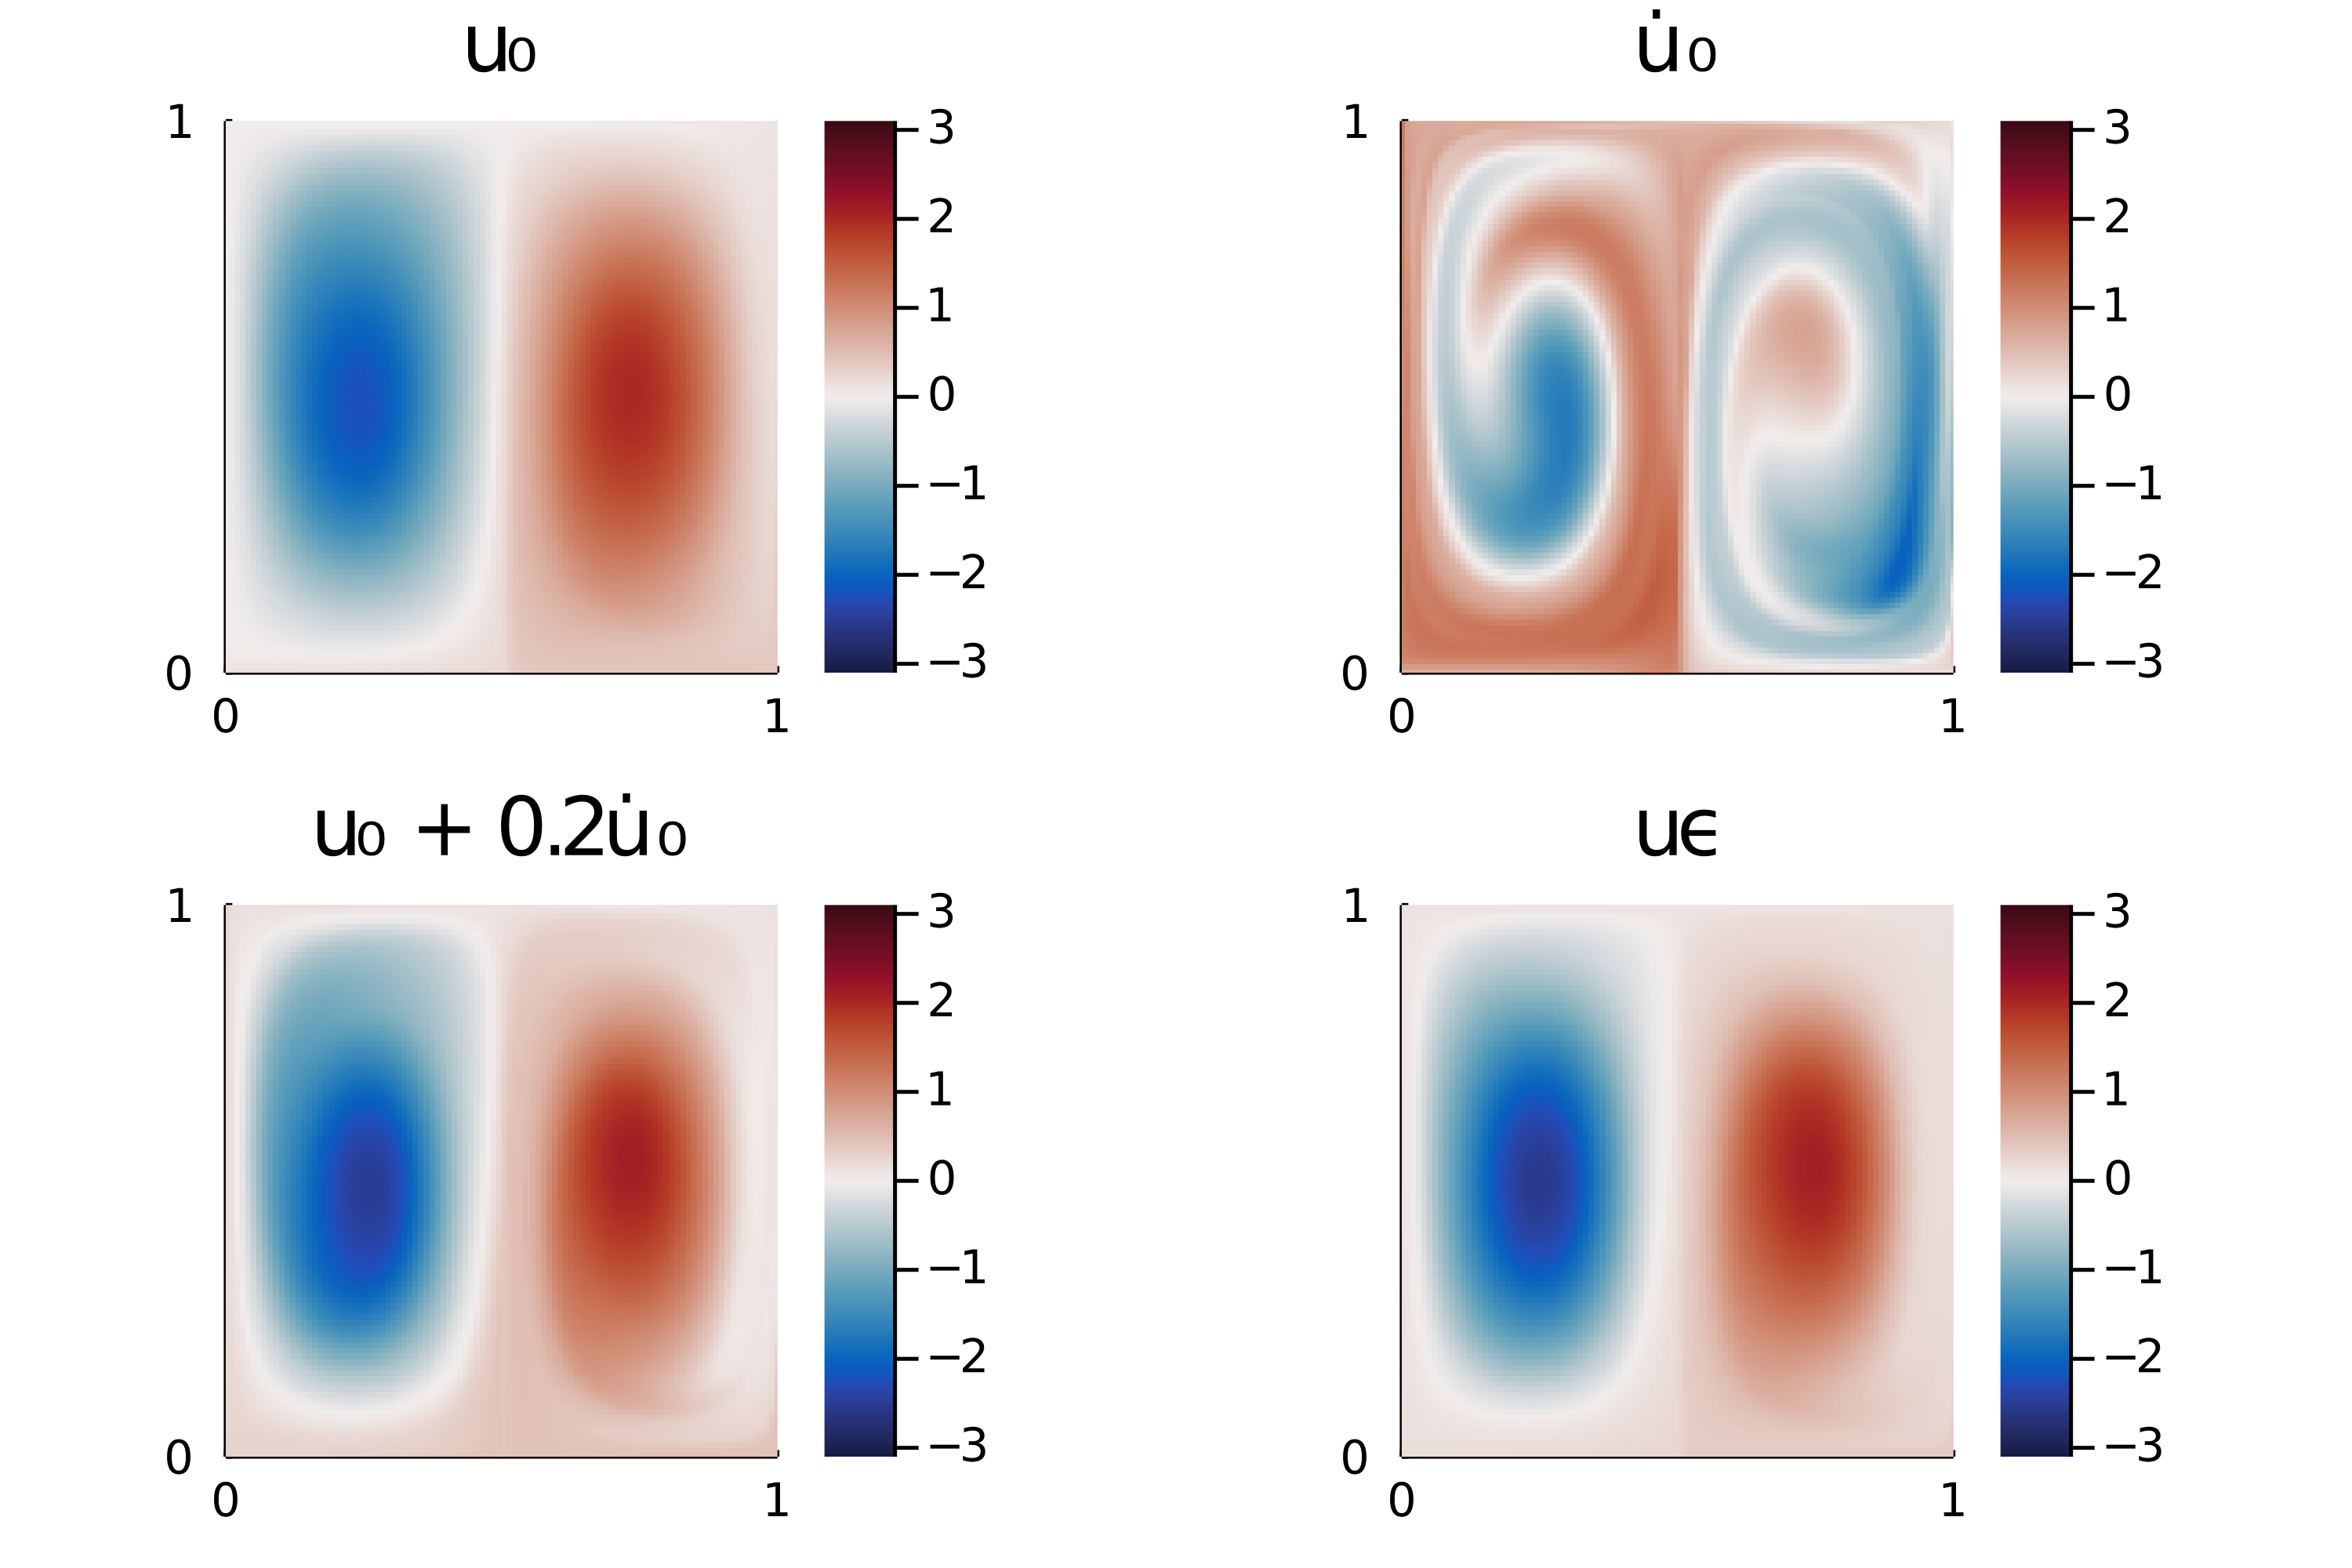

In [14]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [15]:
using StaticArrays
using Contour

In [16]:
#only works for 2D
function apply2curve(flowmap, curve::Curve2{T}) where {T}
    moved_points = [flowmap(x) for x in zip(coordinates(curve)...)]
    return Curve2(moved_points)   
end

apply2curve (generic function with 1 method)

In [17]:
function getLength(curve, tensorfield=(x,y) -> 1)
    xs, ys = coordinates(curve)
    n = length(xs)
    result = 0
    for j in 1:(n-1)
        current_x, current_y   = xs[j], ys[j]
        next_x, next_y         = xs[j+1], ys[j+1]
        approxTangentVector = [next_x - current_x, next_y - current_y]
        result += sqrt(approxTangentVector ⋅ (tensorfield(curx, cury) * approxTangentVector))
    end
    return result
end

getLength (generic function with 2 methods)

In [18]:
# from contour.jl we only get the guarantee that either the first and last points are equal, or the contour starts and
# ends at the boundary of Ω. in the last case, we will have to construct a closed curve e.g. in order to determine the
# enclosed area
function closeCurve(ctx,curve::Curve2{T};tolerance=0.0) where {T}
    xs, ys = coordinates(curve)
    start_x, start_y, end_x, end_y = xs[1], ys[1], xs[end], ys[end]
    
    if (start_x == end_x && start_y == end_y)
        return curve
    end  
    
    points = [SA[x,y] for (x,y) in zip(xs,ys)]

    LL, UR = ctx.spatialBounds
    #Curve2 wants StaticArrays
    LL, UR = SA[LL[1], LL[2]], SA[UR[1], UR[2]]
    LR, UL = SA[UR[1], LL[2]], SA[LL[1], UR[2]] 
    corners = [LR, UR, UL, LL]
    
    # we order them like
    #       3
    #       --
    #    4 |  | 2
    #       --
    #       1
    # and corners[i] points to the next anti-clockwise corner on side i
    
    function determine_side(x,y)
        if     abs(y-LL[2])<=tolerance
            return 1
        elseif abs(x-LR[1])<=tolerance
            return 2
        elseif abs(y-UR[2])<=tolerance
            return 3
        elseif abs(x-UL[1])<=tolerance
            return 4
        else                              # point does not lie on the boundary
            error("A curve has either to be closed or start and end at the boundary!")
        end
    end
    
    
    #last point has to be on one of the 4 sides
    side = determine_side(end_x,end_y)
    
    i = 0
    while(abs(start_x-end_x)>tolerance && abs(start_y-end_y)>tolerance)
        push!(points,corners[side])
        end_x = corners[side][1]
        end_y = corners[side][2]
        side = (side%4)+1
        i += 1
        if i>4  # might happen if the first point is not on the border, prevent infinite loops
            error("A curve has either to be closed or start and end at the boundary!")
        end
    end
    push!(points,points[1])  # close curve
    return Curve2(points)
end

closeCurve (generic function with 1 method)

In [19]:
# If the first point is not the last point, we might get vol(Ω)-area instead
function getEuclideanArea(ctx,curve,tolerance=0.0)
    
    curve = closeCurve(ctx,curve,tolerance=tolerance)
        
    xs, ys = coordinates(curve)
    center_x, center_y = mean(xs), mean(ys)
    n = length(xs)
    result = 0.0
    for j in 1:(n-1)
        current_x, current_y   = xs[j], ys[j]
        next_x, next_y         = xs[j+1], ys[j+1]

        x1 = current_x - center_x
        x2 = next_x - center_x
        y1 = current_y - center_y
        y2 = next_y - center_y
        
        area = 0.5*det([x2 y2; x1 y1])
        result +=area
    end
    return abs(result)
end

getEuclideanArea (generic function with 2 methods)

In [20]:
function dynamic_cheeger_value(ctx, curve, flowmap; tolerance=0.0)
    LL, UR = ctx.spatialBounds
    volume_Ω = (UR[1] - LL[1]) * (UR[2] - LL[2])
    image_curve = apply2curve(flowmap,curve)
    volume_curve = getEuclideanArea(ctx,curve,tolerance)
    return 0.5*(getLength(curve) + getLength(image_curve)) / min(volume_curve, (volume_Ω - volume_curve))
end

dynamic_cheeger_value (generic function with 1 method)

In [28]:
function get_minimal_levelset(ctx, u, objective_function; n_candidates=10, bdata=BoundaryData())
    xs = range(ctx.spatialBounds[1][1], stop=ctx.spatialBounds[2][1], length=ctx.numberOfPointsInEachDirection[1])
    ys = range(ctx.spatialBounds[1][2], stop=ctx.spatialBounds[2][2], length=ctx.numberOfPointsInEachDirection[2])

    u_dofvals = undoBCS(ctx, u, bdata)
    u_nodevals = u_dofvals[ctx.node_to_dof]

    fs = [evaluate_function_from_node_or_cellvals(ctx, u_nodevals, Vec{2}((x,y)))
        for x in xs, y in ys]

    currentmin = Inf
    result = nothing
    
    for cl in levels(contours(xs, ys, fs, n_candidates))
        value = objective_function(cl)
        if value < currentmin
            currentmin = value
            result = cl
        end
    end
    return result, currentmin
end

get_minimal_levelset (generic function with 1 method)

In [22]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        throw("Currently only connected levelsets are allowed!")
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,ϵ),tolerance=1e-10)
end

dynamic_cheeger_value_levelset (generic function with 1 method)

Dynamic Cheeger value: 5.663464662128357
Levelset: 0.08312925183277109


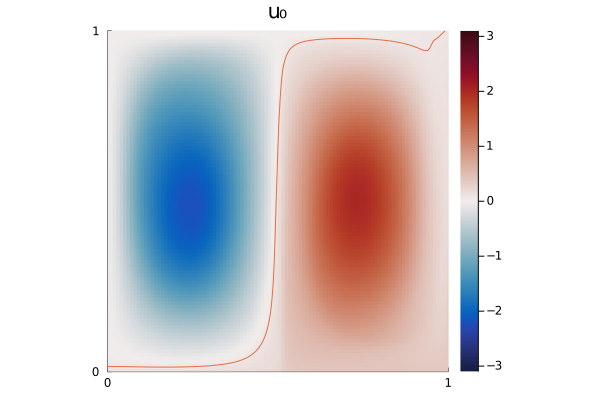

In [34]:
plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

levelset, value = get_minimal_levelset(ctx,u₀,dynamic_cheeger_value_levelset,n_candidates=100)
print("Dynamic Cheeger value: ",value,"\n")
print("Levelset: ",level(levelset),"\n")

xs, ys = coordinates(lines(levelset)[1])
Plots.plot!(xs,ys)